# WWZ benchmark

In this notebook, we will learn how to use the WWZ function of the `pyleoclim` package to do spectral anlaysis on a timeseries.
In detail, what we will do includes:
+ Generate an evenly-spaced colored noise timeseries with a scaling exponent of 1 as an ideal test, comparing WWZ and MTM
+ Delete 25% points of the timeseries randomly to create a unevenly-spaced timeseries to test the performance of WWZ handling nonuniform sampling
+ Benchmark the decaying constant in the WWZ function
+ Wavelet analysis using WWZ


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from pyleoclim import Spectral

## Generate evenly-spaced timeseries and delete some points

Let's first define a function to generate colored noise with a given scaling exponent.

In [2]:
def gen_noise(alpha, t, f0=None, m=None):
    ''' Generate a colored noise timeseries

    Args:
        alpha (float): exponent of the 1/f^alpha noise
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the highest frequency of the components in the synthetic noise

    Returns:
        y (array): the generated 1/f^alpha noise

    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies. Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n

    k = np.arange(m) + 1  # wave numbers

    theta = np.random.rand(int(m))*2*np.pi  # random phase
    for j in range(n):
        coeff = (k*f0)**(-alpha/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

Now let's generate an evenly-spaced colored noise timeseries with the scaling exponent of 1, and then delete 25% points randomly to create a unevenly-spaced timeseries.

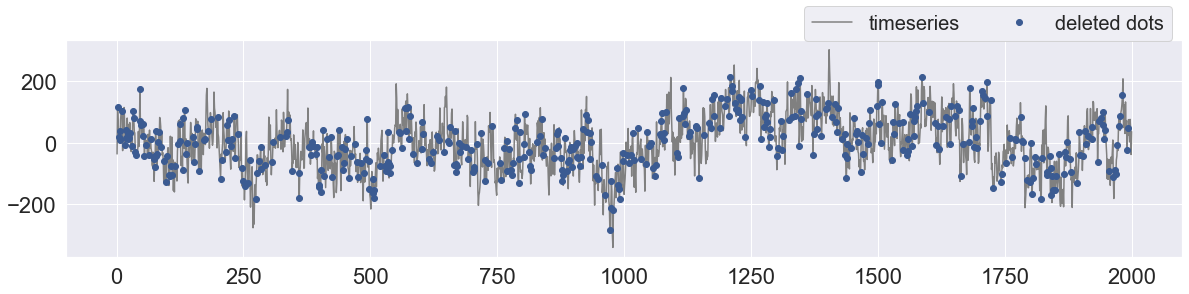

In [3]:
np.random.seed(2333)

to_evenly = np.arange(1, 2001)
Xo_evenly = gen_noise(1, to_evenly, m=np.size(to_evenly)/2)  # set such m so that no aliasing occurs

n_del = 500  # delete 500 pts from 2000 pts
deleted_idx = np.random.choice(range(np.size(to_evenly)), n_del, replace=False)

to_unevenly =  np.delete(to_evenly, deleted_idx)
Xo_unevenly =  np.delete(Xo_evenly, deleted_idx)

sns.set(style="darkgrid", font_scale=2)
plt.subplots(figsize=[20, 4])
plt.plot(to_evenly, Xo_evenly, color='gray', label='timeseries')
plt.plot(to_evenly[deleted_idx], Xo_evenly[deleted_idx], 'o', color=sns.xkcd_rgb['denim blue'], label='deleted dots')
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.2), loc='upper right', ncol=3)

In [4]:
# show the location of the deleted points
print(np.sort(deleted_idx))

[   1    4    5    6    9   16   17   18   19   21   22   24   26   30
   32   33   36   37   45   46   47   51   52   54   57   62   66   72
   74   75   76   77   78   80   82   87   93   97   98  103  104  107
  109  115  120  124  125  129  130  133  135  137  150  152  154  157
  158  161  172  173  180  186  198  204  206  214  216  218  221  225
  226  231  233  238  247  248  252  258  261  273  275  279  283  284
  292  305  308  322  333  334  337  345  358  359  378  380  382  384
  386  392  394  397  398  401  402  406  407  413  417  422  424  434
  436  437  443  445  448  449  453  458  461  468  473  475  481  487
  490  491  493  496  497  504  505  506  507  519  525  527  530  533
  534  535  537  538  541  556  557  561  568  570  571  573  575  577
  583  591  600  601  603  614  618  622  631  635  644  653  654  656
  664  665  667  668  669  674  676  680  687  692  697  701  703  704
  709  718  724  725  730  739  755  757  763  768  769  772  777  778
  780 

## Compare PSDs of evenly/unevenly-spaced timeseries

Now we will use the function `Spectral.wwz_psd()` to do spectral analysis on the evenly/unevenly-spaced timeseries using WWZ method.
Also we will calculate the analytical PSD, as well as the PSD calculated with MTM for comparison.

In [5]:
%%time

freqs = None
tau_evenly = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)
tau_unevenly = np.linspace(np.min(to_unevenly), np.max(to_unevenly), 101)
dcon = 1e-3

res_psd_evenly = Spectral.wwz_psd(Xo_evenly, to_evenly, freqs=freqs, tau=tau_evenly, c=dcon, standardize=False, nMC=0, anti_alias=False)
res_psd_unevenly = Spectral.wwz_psd(Xo_unevenly, to_unevenly, freqs=freqs, tau=tau_unevenly, c=dcon, standardize=False, nMC=0, anti_alias=False)
res_psd_unevenly_high_dcon = Spectral.wwz_psd(Xo_unevenly, to_unevenly, freqs=freqs, tau=tau_unevenly, c=0.02, standardize=False, nMC=0, anti_alias=False)

CPU times: user 44 s, sys: 122 ms, total: 44.1 s
Wall time: 5.78 s


In [6]:
# analytical PSD
psd_ideal_ref = 0.5*res_psd_evenly.freqs**(-1)/(1/np.size(to_evenly))

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  


In [7]:
# PSD calculated with MTM for comparison
import nitime.algorithms as tsa
freq_mtm, psd_mtm, nu = tsa.multi_taper_psd(Xo_evenly, adaptive=False, jackknife=False, NW=2, Fs=1)

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))


We can use the function `Spectral.beta_estimation()` to estimate the scaling exponent of a PSD curve within a frequency range as below.

In [8]:
freq_range = [1/200, 1/2]  # range for beta estimation

res_beta_evenly = Spectral.beta_estimation(
    res_psd_evenly.psd, res_psd_evenly.freqs, freq_range[0], freq_range[1]
)

res_beta_unevenly = Spectral.beta_estimation(
    res_psd_unevenly.psd, res_psd_unevenly.freqs, freq_range[0], freq_range[1]
)

res_beta_unevenly_high_dcon = Spectral.beta_estimation(
    res_psd_unevenly_high_dcon.psd, res_psd_unevenly_high_dcon.freqs, freq_range[0], freq_range[1]
)

res_beta_mtm = Spectral.beta_estimation(
    psd_mtm, freq_mtm, freq_range[0], freq_range[1]
)

Now let's plot and compare the PSD curves.

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/pyleoclim-0.4.8-py3.6.egg/pyleoclim/Spectral.py:2574: RuntimeWarning: divide by zero encountered in true_divide
  x_data = 1 / freqs
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/pyleoclim-0.4.8-py3.6.egg/pyleoclim/Spectral.py:2576: RuntimeWarning: divide by zero encountered in true_divide
  x_data_ar1 = 1 / freqs
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/

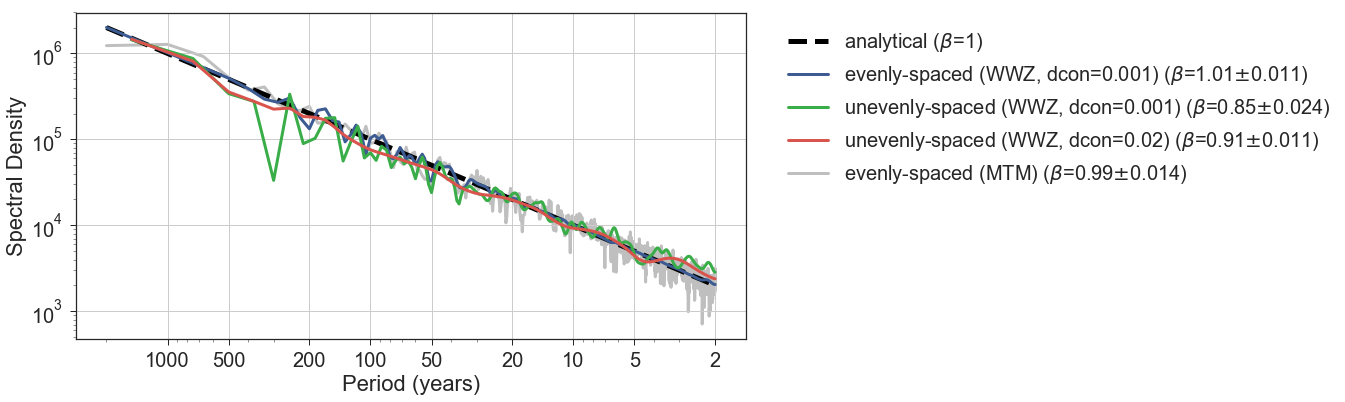

In [9]:
period_ticks = [2, 5, 10, 20, 50, 100, 200, 500, 1000]

fig = Spectral.plot_psd(psd_ideal_ref, res_psd_evenly.freqs, plot_ar1=False, psd_ar1_q95=None, period_ticks=period_ticks, lmstyle='--', color='k', label=r'analytical ($\beta$=1)'.format(res_beta_evenly.beta), figsize=[12, 6], linewidth=5)
plt.plot(1/res_psd_evenly.freqs, res_psd_evenly.psd, '-', linewidth=3, label=r'evenly-spaced (WWZ, dcon=0.001) ($\beta$={:.2f}$\pm${:.3f})'.format(res_beta_evenly.beta, res_beta_evenly.std_err), color=sns.xkcd_rgb['denim blue'])
plt.plot(1/res_psd_unevenly.freqs, res_psd_unevenly.psd, '-', linewidth=3, label=r'unevenly-spaced (WWZ, dcon=0.001) ($\beta$={:.2f}$\pm${:.3f})'.format(res_beta_unevenly.beta, res_beta_unevenly.std_err), color=sns.xkcd_rgb['medium green'])
plt.plot(1/res_psd_unevenly_high_dcon.freqs, res_psd_unevenly_high_dcon.psd, '-', linewidth=3, label=r'unevenly-spaced (WWZ, dcon=0.02) ($\beta$={:.2f}$\pm${:.3f})'.format(res_beta_unevenly_high_dcon.beta, res_beta_unevenly_high_dcon.std_err), color=sns.xkcd_rgb['pale red'])
plt.plot(1/freq_mtm, psd_mtm, '-', linewidth=3, label=r'evenly-spaced (MTM) ($\beta$={:.2f}$\pm${:.3f})'.format(res_beta_mtm.beta, res_beta_mtm.std_err), color='gray', alpha=0.5, zorder=-1)

# plt.plot(1/res_beta_evenly.f_binned, res_beta_evenly.Y_reg, '--', color='k', linewidth=3, zorder=99)
# plt.plot(1/res_beta_unevenly.f_binned, res_beta_unevenly.Y_reg, '--', color='k', linewidth=3, zorder=99)
# plt.plot(1/res_beta_mtm.f_binned, res_beta_mtm.Y_reg, '--', color='k', linewidth=3, zorder=99)

plt.legend(fontsize=20, bbox_to_anchor=(1.9, 1), loc='upper right', ncol=1)

The figure above indicates that in the case of an evenly-spaced timeseries, both WWZ and MTM give good estimates of the analytical PSD.
WWZ gives almost accurate PSD over the high frequency band (2-20 yrs), while MTM gives big oscillations there.

When we delete 25% of the data, making the timeseries unevenly-spaced, WWZ with a small decaying constant gives lower estimate of the scaling exponent due to aliasing caused by nonuniform sampling, and a larger decaying constant helps a bit.

## Benchmark the decaying constant

The decaying constant will affect the frequency resolution of the WWZ method. Larger constant results in smoother PSD curve, as shown below.

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/pyleoclim-0.4.8-py3.6.egg/pyleoclim/Spectral.py:2574: RuntimeWarning: divide by zero encountered in true_divide
  x_data = 1 / freqs
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/pyleoclim-0.4.8-py3.6.egg/pyleoclim/Spectral.py:2576: RuntimeWarning: divide by zero encountered in true_divide
  x_data_ar1 = 1 / freqs
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


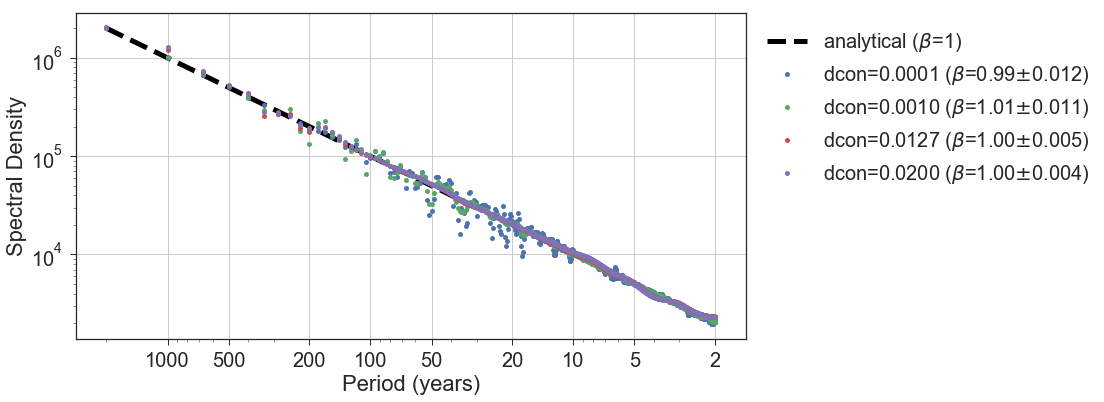

In [10]:
freqs = None
tau_evenly = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)
res_psd = {}
res_beta = {}
freq_range = [1/200, 1/2]  # range for beta estimation

# dcon options:
# + 1/(8*np.pi**2) from Witt & Schumann 2005
# + 0.0125 from Foster 1996, very close to 1/(8*np.pi**2)
# + 0.001 from Kirchner & Neal 2013
fig = Spectral.plot_psd(psd_ideal_ref, res_psd_evenly.freqs, plot_ar1=False, psd_ar1_q95=None, period_ticks=period_ticks,
                        lmstyle='--', color='k', label=r'analytical ($\beta$=1)'.format(res_beta_evenly.beta), figsize=[12, 6], linewidth=5)
for dcon in [0.0001, 0.001, 1/(8*np.pi**2), 0.02]:
    res_psd[str(dcon)] = Spectral.wwz_psd(Xo_evenly, to_evenly, freqs=freqs, tau=tau_evenly, c=dcon, standardize=False, nMC=0, anti_alias=False)
    res_beta[str(dcon)] = Spectral.beta_estimation(
                          res_psd[str(dcon)].psd, res_psd[str(dcon)].freqs, freq_range[0], freq_range[1]
                      )
    plt.plot(1/res_psd[str(dcon)].freqs, res_psd[str(dcon)].psd, 'o', ms=5, linewidth=3, label='dcon={:.4f} '.format(dcon)+r'($\beta$={:.2f}$\pm${:.3f})'.format(res_beta[str(dcon)].beta, res_beta[str(dcon)].std_err))
                 
plt.legend(fontsize=20, bbox_to_anchor=(1.54, 1), loc='upper right', ncol=1)

## Wavelet analysis

Now let's do some wavelet analysis on both the evenly/unevenly-spaced data. Note that `nMC` sets the number of Monte-Carlo simulations for significance test.

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Monte-Carlo simulations: 100%|███████

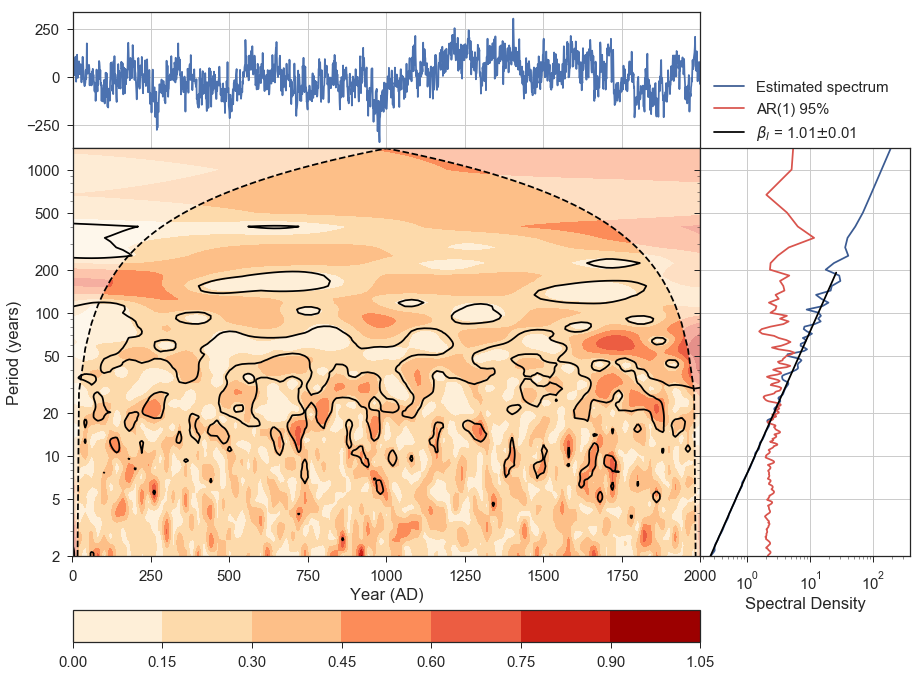

In [11]:
# evenly-spaced timeseries
freqs = None
tau_evenly = np.linspace(np.min(to_evenly), np.max(to_evenly), 101)
freq_range = [1/200, 1/2]
period_ticks = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
fig = Spectral.plot_summary(Xo_evenly, to_evenly, nMC=5, ts_style='-', tau=tau_evenly, period_ticks=period_ticks, period_S=freq_range, period_L=None)

/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/fzhu/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Monte-Carlo simulations: 100%|███████

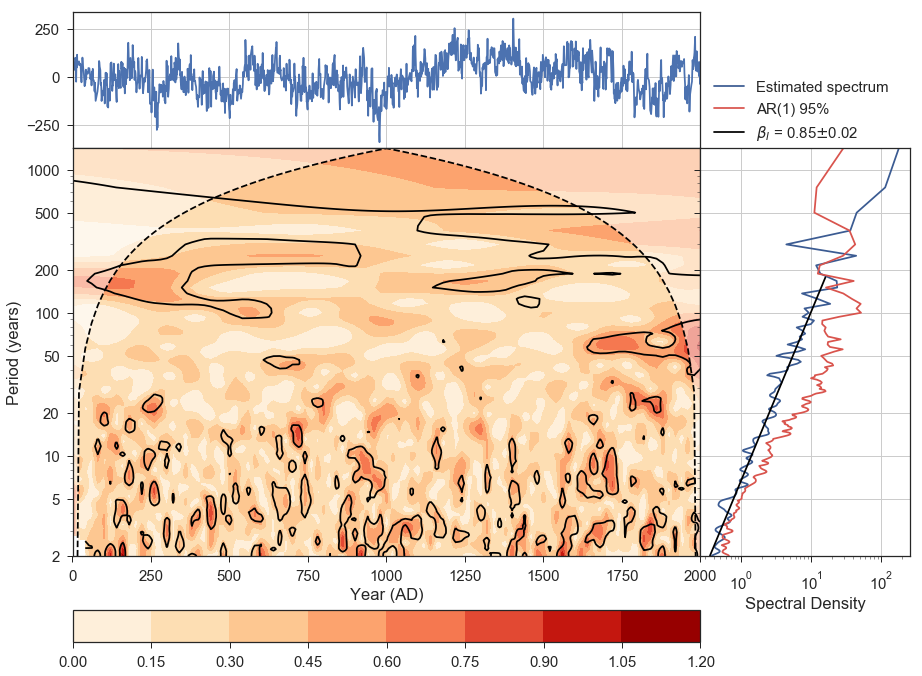

In [12]:
# unevenly-spaced timeseries
freqs = None
tau_unevenly = np.linspace(np.min(to_unevenly), np.max(to_unevenly), 101)
freq_range = [1/200, 1/2]
period_ticks = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
fig = Spectral.plot_summary(Xo_unevenly, to_unevenly, nMC=5, ts_style='-', tau=tau_unevenly, period_ticks=period_ticks, period_S=freq_range, period_L=None)